# Table of Contents

    1) Introduction
    2) Data Preparation
    3) Exploratory Data Analysis
    4) Collaborative Filter
        4.1) SVD
        4.2) KNN 
    5) Predictive Accuracy Metrics

# 1) Introduction

### Project Description
This project is done for the course system development for marketing of the Master Digital Driven Business. The goal of this project is to make a recommender system for Netflix and Jester.

### Business Questions
Main Business question:
- How can we use collaborative filtering to improve the success rate of a new movie streaming platform and increase the satisfaction of backers?

Sub-questions:
- Which collaborative algorithm should be implemented to effectivily recommend products to users based on their preferences?
- How can we personalize the crowdfunding experience for backers?
- How can the performance of the chosen collaborative algorithms be optimized?
- What measures can we take to ensure that the collaborative filtering recommender system is fair and transparent?
- Which metrics can we utilize to accurately measure the performance of the collaborative filtering recommender system?

For companies it is very important to know their customers and what to recommend to improve customer staisfaction and loyalty.
Therefore, a recommender system will be build using collaborative filter.

# 2) Dataset Preparation

In [1]:
# Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Surprise library
from surprise import Reader, Dataset, accuracy, SVD, NMF, KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [2]:
# Importing Datasets
movie_titles_df = pd.read_csv("movie_titles.txt", encoding='latin1', on_bad_lines='skip')
movie_titles_df.columns=["movie_id", "year", "name"]

In [3]:
# Only importing the first 4500 movies, since the data is too big to load
movie_ratings_df = pd.read_csv("combined1.txt", names = ['cust_id', 'rating'], usecols = [0, 1])
#movie_ratings_df2 = pd.read_csv("combined2.txt", names = ['cust_id', 'rating'], usecols = [0, 1])
#movie_ratings_df3 = pd.read_csv("combined3.txt", names = ['cust_id', 'rating'], usecols = [0, 1])
#movie_ratings_df4 = pd.read_csv("combined4.txt", names = ['iust_id', 'rating'], usecols = [0, 1])

#probe = pd.read_csv('probe.txt', names=['user_id'])

In [4]:
movie_ratings_df

,cust_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058517,1154902,5.0
24058518,2236573,3.0
24058519,2448838,5.0
24058520,1983272,4.0


In [5]:
# https://www.kaggle.com/code/igorlukas/netflix-prize-igorluk
# Function to extract the movie id from the data
def extract_movie_id(cust_id):
    if cust_id[-1] == ':':
        return cust_id[:-1]
    else:
        return None

movie_ratings_df['movie_id'] = movie_ratings_df['cust_id'].apply(extract_movie_id) # Add column movie id when user_id have last letter ':'
movie_ratings_df['movie_id'] = movie_ratings_df['movie_id'].fillna(method='ffill') # Fill forward all NaN values of movie_id.
movie_ratings_df.dropna(subset=['rating'], inplace=True) # Drop all rows where rating is Nan
movie_ratings_df.reset_index(drop=True, inplace=True) # Reset index 
print(movie_ratings_df)

          cust_id  rating movie_id
0         1488844     3.0        1
1          822109     5.0        1
2          885013     4.0        1
3           30878     4.0        1
4          823519     3.0        1
...           ...     ...      ...
24054017  1154902     5.0     4500
24054018  2236573     3.0     4500
24054019  2448838     5.0     4500
24054020  1983272     4.0     4500
24054021  1400108     4.0     4500

[24054022 rows x 3 columns]


In [6]:
# Finding the distribution of different ratings in the datset
p = movie_ratings_df.groupby('rating')['rating'].count()
p

rating
1.0    1118203
2.0    2439113
3.0    6904259
4.0    8085828
5.0    5506619
Name: rating, dtype: int64

In [7]:
# The dimensions of the netflix dataframe
print('The dimensions of the netflix dataframe are: ', movie_ratings_df.shape)

The dimensions of the netflix dataframe are:  (24054022, 3)


In [8]:
movie_ratings_df.describe()

,rating
count,2.405402e+07
mean,3.599631e+00
std,1.086119e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [9]:
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24054022 entries, 0 to 24054021
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   cust_id   object 
 1   rating    float64
 2   movie_id  object 
dtypes: float64(1), object(2)
memory usage: 550.6+ MB


In [10]:
movie_ratings_df['cust_id'] = movie_ratings_df['cust_id'].astype(int)
movie_ratings_df['movie_id'] = movie_ratings_df['movie_id'].astype(int)

In [11]:
print(movie_ratings_df.isnull().sum())

cust_id     0
rating      0
movie_id    0
dtype: int64


In [12]:
# Since the data is too large, we have to take a subset of the data by using specific criterias for the users and movies
print("Original length of the dataframe: ", len(movie_ratings_df))
# Counting Users that have not rated more than 300 movies
usercount = movie_ratings_df[["movie_id", "cust_id"]].groupby("cust_id").count()
print("There are ", usercount.shape[0], "unique users")
usercount = usercount[usercount["movie_id"]>300]
print("There are ", usercount.shape[0], "unique users that have rated more than 300 movies")

# Counting Jokes that do not have more than 5000 ratings
moviecount = movie_ratings_df[["movie_id", "cust_id"]].groupby("movie_id").count()
print("There are ", moviecount.shape[0], "unique movies")
moviecount = moviecount[moviecount["cust_id"]>5000]
print("There are ", moviecount.shape[0], "unique movies that have more than 5000 ratings")

# Removing the unactive users and unpopular jokes from the df
movie_ratings_df = movie_ratings_df[movie_ratings_df["cust_id"].isin(usercount.index) & movie_ratings_df["movie_id"].isin(moviecount.index)]
print("\nSubset of data: ")
print(movie_ratings_df)

Original length of the dataframe:  24054022
There are  470758 unique users
There are  7016 unique users that have rated more than 300 movies
There are  4500 unique movies
There are  774 unique movies that have more than 5000 ratings

Subset of data: 
          cust_id  rating  movie_id
5111      1744889     1.0         8
5149      1488844     4.0         8
5167       306466     4.0         8
5181       573364     1.0         8
5198      1148143     2.0         8
...           ...     ...       ...
24052326  1704416     4.0      4496
24052336  2082452     3.0      4496
24052343    15737     4.0      4496
24052344   823628     5.0      4496
24052346  1055714     5.0      4496

[2138037 rows x 3 columns]


# 3) Exploratory Data Analysis

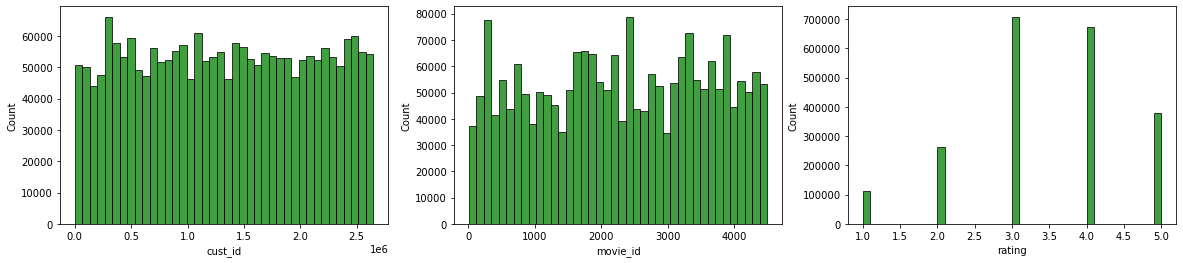

In [13]:
# Histogram plots of various variables
fig = plt.figure(figsize=(20, 4))

plt.subplot(1,3,1)
sns.histplot(data=movie_ratings_df, x="cust_id", element="bars", color=['green'], bins=40)

plt.subplot(1,3,2)
sns.histplot(data=movie_ratings_df, x="movie_id", element="bars", color=['green'], bins=40)

plt.subplot(1,3,3)
sns.histplot(data=movie_ratings_df, x="rating", element="bars", color=['green'], bins=40)

plt.show()

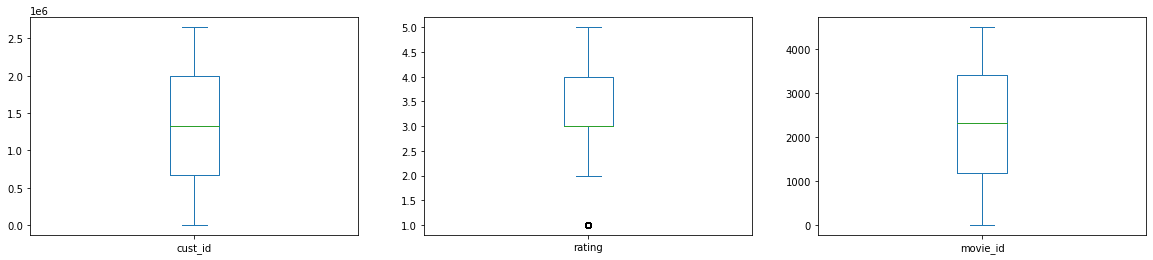

In [14]:
# Boxplots of various variables
movie_ratings_df.plot(kind = "box", subplots = True, figsize = (20,4), layout = (1,3))
plt.show()

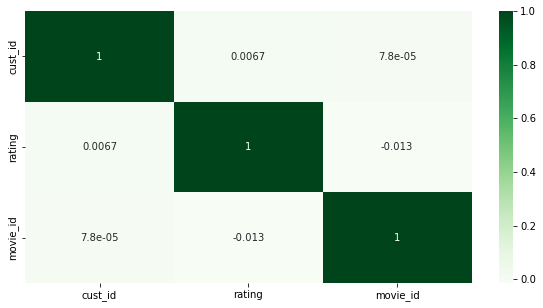

In [15]:
# Correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(movie_ratings_df.corr(),cbar=True,annot=True,cmap='Greens')
plt.show()

# 4) Collaborative Filter with Surprise

## 4.1) Code with Surprise and SVD (User based)

In [16]:
# Hyperparameter tuning with GridSearch
#parameters = {"n_factors": [5, 50, 100],
#              "reg_all": [0.04, 0.06],
#              "n_epochs": [5, 20, 30, 40],
#              "lr_all": [.005, .01, .05]}
#gridsvd = GridSearchCV(SVD, param_grid=parameters, n_jobs=-1)
#gridsvd.fit(svd_data)
#print(gridsvd.best_score)
#print(gridsvd.best_params)

In [17]:
svd = SVD(n_factors=100, reg_all=0.04, n_epochs=40, lr_all=.005)

In [18]:
# Loading the Data
reader = Reader(rating_scale=(1, 5))
svd_data = Dataset.load_from_df(movie_ratings_df[['cust_id', 'movie_id', 'rating']], reader)

In [19]:
# Test the model on the testing set
svd_trainset, svd_testset = train_test_split(svd_data, test_size=0.2)
svd.fit(svd_trainset)
svd_predictions = svd.test(svd_testset)

# Printing users actual ratings and the predicted ratings
for prediction in svd_predictions[0:10]:
    print(prediction)

user: 686173     item: 3954       r_ui = 5.00   est = 4.00   {'was_impossible': False}
user: 2320706    item: 4248       r_ui = 4.00   est = 3.71   {'was_impossible': False}
user: 2621962    item: 3290       r_ui = 5.00   est = 4.66   {'was_impossible': False}
user: 1719780    item: 30         r_ui = 3.00   est = 3.52   {'was_impossible': False}
user: 2395304    item: 1837       r_ui = 3.00   est = 3.66   {'was_impossible': False}
user: 1477153    item: 2940       r_ui = 2.00   est = 2.17   {'was_impossible': False}
user: 519965     item: 2944       r_ui = 3.00   est = 3.56   {'was_impossible': False}
user: 1637761    item: 4266       r_ui = 3.00   est = 2.59   {'was_impossible': False}
user: 2341389    item: 3923       r_ui = 1.00   est = 2.39   {'was_impossible': False}
user: 194528     item: 2072       r_ui = 3.00   est = 2.76   {'was_impossible': False}


In [20]:
# Print the performance metrics
accuracy.rmse(svd_predictions)

RMSE: 0.8105


0.8105009556707427

In [21]:
# Inspiration from https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation (need APA style)
# Function to recommend an user a number of recommendations
def recommend_SVD(cust_id, num_recommendations):
    user_df = movie_titles_df.copy()
    user_df = user_df.reset_index()

    data = Dataset.load_from_df(movie_ratings_df[['cust_id', 'movie_id', 'rating']], reader)

    trainset = data.build_full_trainset()
    svd.fit(trainset)

    user_df['Estimate_Score'] = user_df['movie_id'].apply(lambda x: svd.predict(cust_id, x).est)

    user_df = user_df.drop((['index', 'movie_id', 'year']), axis = 1)
    user_df = user_df.sort_values('Estimate_Score', ascending=False)
    print(user_df.head(num_recommendations))

In [22]:
# Recommend user 100 with the top 10 movies
recommend_SVD(100, 10)

                                               name  Estimate_Score
3390                                 Lost: Season 1        4.565986
2409  Lord of the Rings: The Fellowship of the Ring        4.379733
4224                                The Sixth Sense        4.303711
2809                       The Silence of the Lambs        4.300020
2066                         The Simpsons: Season 6        4.240121
2125                                  CSI: Season 1        4.238263
3792                                  Batman Begins        4.208981
2732                                     Braveheart        4.202775
2135                         The Simpsons: Season 3        4.156613
3888                      Finding Nemo (Widescreen)        4.153814


## 4.2) Code with Surprise and KNN

In [23]:
# Hyperparameter tuning with GridSearch
#parameters = {"name": ["cosine", "pearson"],
#              "user_based": [True, False],
#              "min_support": [True, False],
#              "min_k": [1, 2, 5]}
#gridknn = GridSearchCV(KNNBasic, param_grid=parameters, n_jobs=-1)
#gridknn.fit(data)
#print(gridknn.best_score)
#print(gridknn.best_params)

In [24]:
# Loading the dataset
reader = Reader(rating_scale=(1, 5))
knn_data = Dataset.load_from_df(movie_ratings_df[['cust_id', 'movie_id', 'rating']][:100000], reader) # using only 100k rows for faster run time

In [25]:
# Fitting a KNNBasic model to the training set
knn = KNNBasic(sim_options={"name": 'pearson',
                            "user_based": True,
                            "min_support": True,
                            "min_k": 1})

In [26]:
# Test the model on the testing set
knn_trainset, knn_testset = train_test_split(knn_data, test_size=0.2)
knn.fit(knn_trainset)
knn_predictions = knn.test(knn_testset)

# Printing users actual ratings and the predicted ratings
for prediction in knn_predictions[0:10]:
    print(prediction)

Computing the pearson similarity matrix...
Done computing similarity matrix.
user: 2198123    item: 108        r_ui = 3.00   est = 3.20   {'actual_k': 40, 'was_impossible': False}
user: 1599231    item: 199        r_ui = 5.00   est = 3.90   {'actual_k': 40, 'was_impossible': False}
user: 1640555    item: 191        r_ui = 5.00   est = 3.83   {'actual_k': 40, 'was_impossible': False}
user: 1611857    item: 118        r_ui = 2.00   est = 3.12   {'actual_k': 40, 'was_impossible': False}
user: 1246893    item: 118        r_ui = 2.00   est = 2.90   {'actual_k': 40, 'was_impossible': False}
user: 1257454    item: 108        r_ui = 2.00   est = 3.33   {'actual_k': 40, 'was_impossible': False}
user: 871687     item: 108        r_ui = 3.00   est = 3.12   {'actual_k': 40, 'was_impossible': False}
user: 1363315    item: 28         r_ui = 5.00   est = 3.58   {'actual_k': 40, 'was_impossible': False}
user: 2445470    item: 223        r_ui = 5.00   est = 4.20   {'actual_k': 40, 'was_impossible': Fal

In [27]:
# Print the performance metrics
accuracy.rmse(knn_predictions)

RMSE: 1.0321


1.0320984000571096

In [28]:
def recommend_KNN(cust_id, num_recommendations):
    user_df = movie_titles_df.copy()
    user_df = user_df.reset_index()

    data = Dataset.load_from_df(movie_ratings_df[['cust_id', 'movie_id', 'rating']][:100000], reader)

    trainset = data.build_full_trainset()
    knn.fit(trainset)

    user_df['Estimate_Score'] = user_df['movie_id'].apply(lambda x: knn.predict(cust_id, x).est)

    user_df = user_df.drop('movie_id', axis = 1, ascending=False)

    user_df = user_df.sort_values('Estimate_Score')
    print(user_df.head(num_recommendations))

In [29]:
# Recommend user 100 with the top 10 jokes
recommend_KNN(100, 10)

Computing the pearson similarity matrix...
Done computing similarity matrix.
       index    year                                      name  Estimate_Score
0          0  2004.0                Isle of Man TT 2004 Review         3.50551
11612  11612  2002.0  Strawberry Shortcake: Get Well Adventure         3.50551
11613  11613  1996.0                 James and the Giant Peach         3.50551
11614  11614  1981.0                           A Good Marriage         3.50551
11615  11615  2001.0                           Sade: Sade Live         3.50551
11616  11616  1944.0                        Tall in the Saddle         3.50551
11617  11617  1997.0                               All Over Me         3.50551
11618  11618  1998.0                           Out of the Past         3.50551
11619  11619  1987.0                               Tragic Hero         3.50551
11620  11620  1952.0                            Victory at Sea         3.50551


In [30]:
# Function where the user can input their user id and the number of recommendation they need
def recommend_KNN_input():
    cust_id = int(input("What is your User ID?"))
    num_recommendations = int(input("How many recommendations do you want?"))
    user_df = movie_titles_df.copy()
    user_df = user_df.reset_index()

    data = Dataset.load_from_df(movie_ratings_df[['cust_id', 'movie_id', 'rating']][:100000], reader)

    trainset = data.build_full_trainset()
    knn.fit(trainset)

    user_df['Estimate_Score'] = user_df['movie_id'].apply(lambda x: knn.predict(cust_id, x).est)

    user_df = user_df.drop('movie_id', axis = 1)

    user_df = user_df.sort_values('Estimate_Score', ascending=False)
    print(user_df.head(num_recommendations))

In [ ]:
# Function where the user gets a random joke and depending if they like or dislike the joke, they get another similar joke
import random

def recommend_KNN_input_2():
    user_df = movie_titles_df.copy()
    user_df = user_df.reset_index()

    data = Dataset.load_from_df(movie_ratings_df[['cust_id', 'movie_id', 'rating']][:100000], reader)

    trainset = data.build_full_trainset()
    knn.fit(trainset)

    # Randomly select a joke
    random_movieId = random.randint(1, 128)
    random_movie_title = user_df.loc[user_df['movie_id'] == random_movieId, 'name'].item()
    print("Here is your movie recommendation: ")
    print(random_movie_title)

    accum = 0
   
    while True:
        liked = input("Do you want a similair movie? Answer with Y or N")
        # Ask the user to continue or leave
        if liked.lower() == 'y':
            user_df['Estimate_Score'] = user_df['movie_id'].apply(lambda x: knn.predict(random_movieId, x).est)
            user_df = user_df.sort_values('Estimate_Score', ascending=False)
            print("Here is another movie recommendation: ")
            print(user_df['name'][accum])
            accum += 1
        else:
            print("Goodbye")
            break

# 5) Predictive accuracy metrics

In [ ]:
# Run 5-fold cross-validation and print results
cross_validate(knn, knn_data, measures=["RMSE", "MAE"], cv=5, verbose=True) # Loading time ~10 minutes

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9495  0.9395  0.9336  0.9476  0.9391  0.9418  0.0059  
MAE (testset)     0.7516  0.7455  0.7396  0.7503  0.7446  0.7463  0.0043  
Fit time          0.60    0.57    0.56    0.56    0.56    0.57    0.01    
Test time         2.32    2.32    2.29    2.31    2.28    2.30    0.02    


{'test_rmse': array([0.94945978, 0.9394827 , 0.93360877, 0.94760951, 0.93908888]),
 'test_mae': array([0.75158312, 0.74551442, 0.73963923, 0.75025191, 0.74458539]),
 'fit_time': (0.5959446430206299,
  0.5658168792724609,
  0.5551180839538574,
  0.5568156242370605,
  0.5632829666137695),
 'test_time': (2.3193154335021973,
  2.322190284729004,
  2.285737991333008,
  2.311873435974121,
  2.2797248363494873)}

In [ ]:
# Run 5-fold cross-validation and print results
cross_validate(svd, svd_data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8284  0.8297  0.8326  0.8307  0.8254  0.8294  0.0024  
MAE (testset)     0.6498  0.6507  0.6535  0.6522  0.6478  0.6508  0.0020  
Fit time          5.80    5.88    5.89    5.86    5.87    5.86    0.03    
Test time         0.72    2.01    0.73    0.70    0.72    0.98    0.51    


{'test_rmse': array([0.82839308, 0.82970504, 0.83257649, 0.83065726, 0.82541817]),
 'test_mae': array([0.64978678, 0.65067839, 0.65352176, 0.65217688, 0.64784157]),
 'fit_time': (5.79892373085022,
  5.875215291976929,
  5.885404109954834,
  5.864975690841675,
  5.874457597732544),
 'test_time': (0.7238659858703613,
  2.0070366859436035,
  0.7333800792694092,
  0.7027847766876221,
  0.7209837436676025)}